In [1]:
import numpy as np
import pandas as pd # for dataframe and CSV handling
import argparse

from sklearn.model_selection import KFold
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.metrics import matthews_corrcoef, roc_auc_score, r2_score, mean_squared_error
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

try:
    import rdkit.Chem.Descriptors as Descriptors
    import rdkit.Chem as Chem
    has_rdkit = True
except:
    has_rdkit = False

from cliques.cliques import get_clique_decomposition

import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
import seaborn as sns

In [2]:
plt.rcParams.update({'font.size': 24})
cmap_discrete = sns.color_palette('colorblind', 10)
cmap_continuous = sns.dark_palette("#69d", reverse=True, as_cmap=True)

In [3]:
data = pd.read_csv('B3DB/B3DB_classification_clean.csv')
data_moleculenet = pd.read_csv('./moleculenet/BBBP_clean.csv')

smiles = data.SMILES

y = (data['BBB+/BBB-'] == 'BBB+').to_numpy().astype(np.int32)

Moleculenet BBBP
BBBP-: 479
BBBP+: 1560
Total: 2039
B3DB BBBP
BBBP-: 2851
BBBP+: 4956
Total: 7807


Text(0, 0.5, 'Number of molecules')

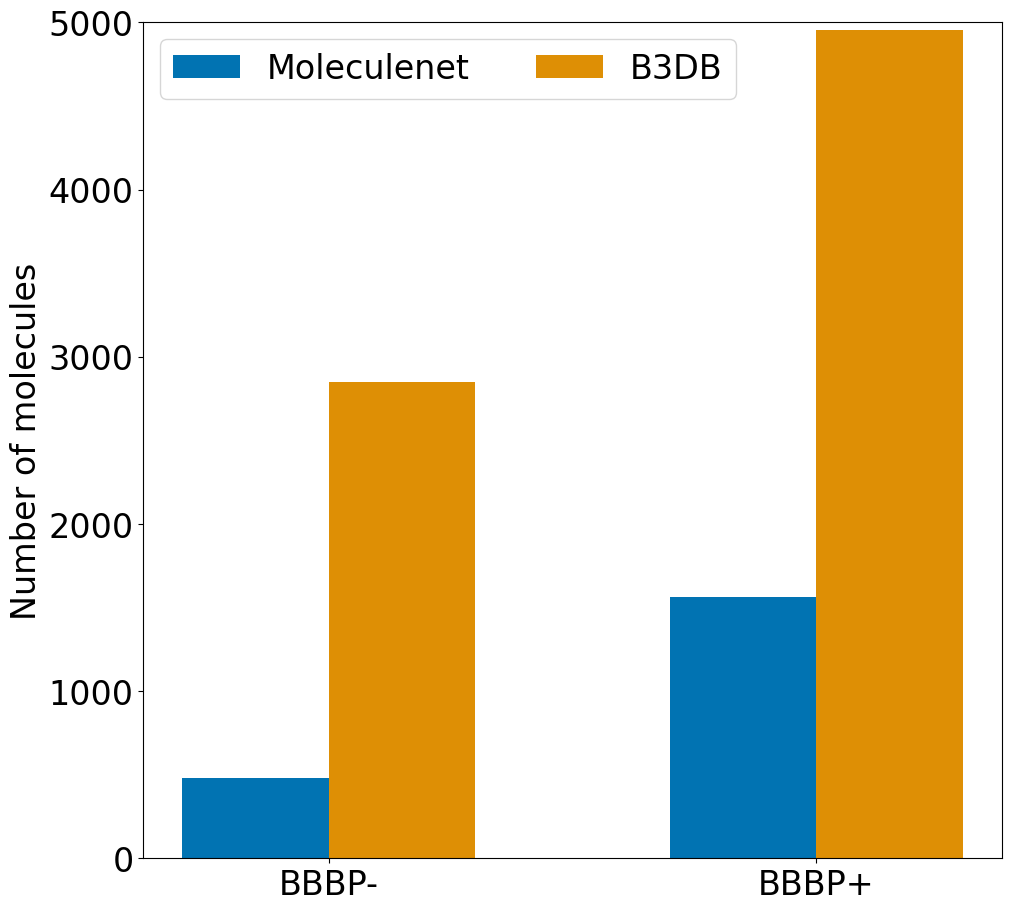

In [4]:
print('Moleculenet BBBP')
print('BBBP-:', len(data_moleculenet[data_moleculenet['p_np'] == 0]))
print('BBBP+:', len(data_moleculenet[data_moleculenet['p_np'] == 1]))
print('Total:', len(data_moleculenet))

print('B3DB BBBP')
print('BBBP-:', len(data[data['BBB+/BBB-'] == 'BBB-']))
print('BBBP+:', len(data[data['BBB+/BBB-'] == 'BBB+']))
print('Total:', len(data))

# plot it both datasets on the same plot
fig, ax = plt.subplots(layout='constrained', figsize=(10,9))
ax.bar(
    [0, 1], [len(data_moleculenet[data_moleculenet['p_np'] == 0]), len(data_moleculenet[data_moleculenet['p_np'] == 1])],
    width=0.3, label='Moleculenet', color=cmap_discrete[0])
ax.bar(
    [0.3, 1.3], [len(data[data['BBB+/BBB-'] == 'BBB-']), len(data[data['BBB+/BBB-'] == 'BBB+'])],
    width=0.3, label='B3DB', color=cmap_discrete[1])
ax.set_xticks([0.15, 1.15], ['BBBP-', 'BBBP+'])
ax.legend(loc='upper left', ncols=2)
ax.set_ylim([0, 5000])
ax.set_ylabel('Number of molecules')

Text(0, 0.5, 'Number of molecules')

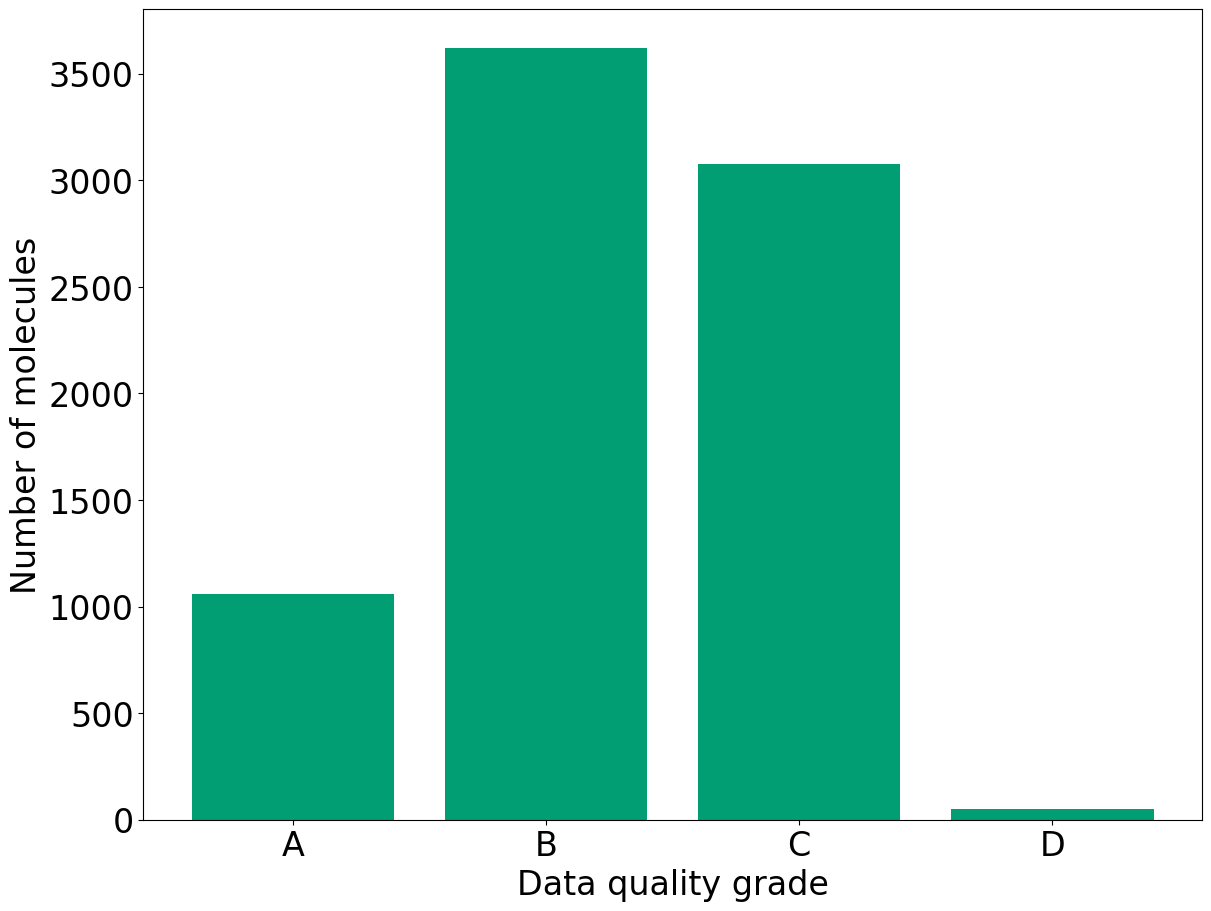

In [5]:
fig, ax = plt.subplots(layout='constrained', figsize=(12,9))
ax.bar(
    ['A', 'B', 'C', 'D'],
    [len(data[data['group'] == 'A']), len(data[data['group'] == 'B']), len(data[data['group'] == 'C']), len(data[data['group'] == 'D'])],
    width=0.8, color=cmap_discrete[2])
ax.set_xlabel('Data quality grade')
ax.set_ylabel('Number of molecules')

(array([-250.,    0.,  250.,  500.,  750., 1000., 1250., 1500., 1750.,
        2000.]),
 [Text(-250.0, 0, '−250'),
  Text(0.0, 0, '0'),
  Text(250.0, 0, '250'),
  Text(500.0, 0, '500'),
  Text(750.0, 0, '750'),
  Text(1000.0, 0, '1000'),
  Text(1250.0, 0, '1250'),
  Text(1500.0, 0, '1500'),
  Text(1750.0, 0, '1750'),
  Text(2000.0, 0, '2000')])

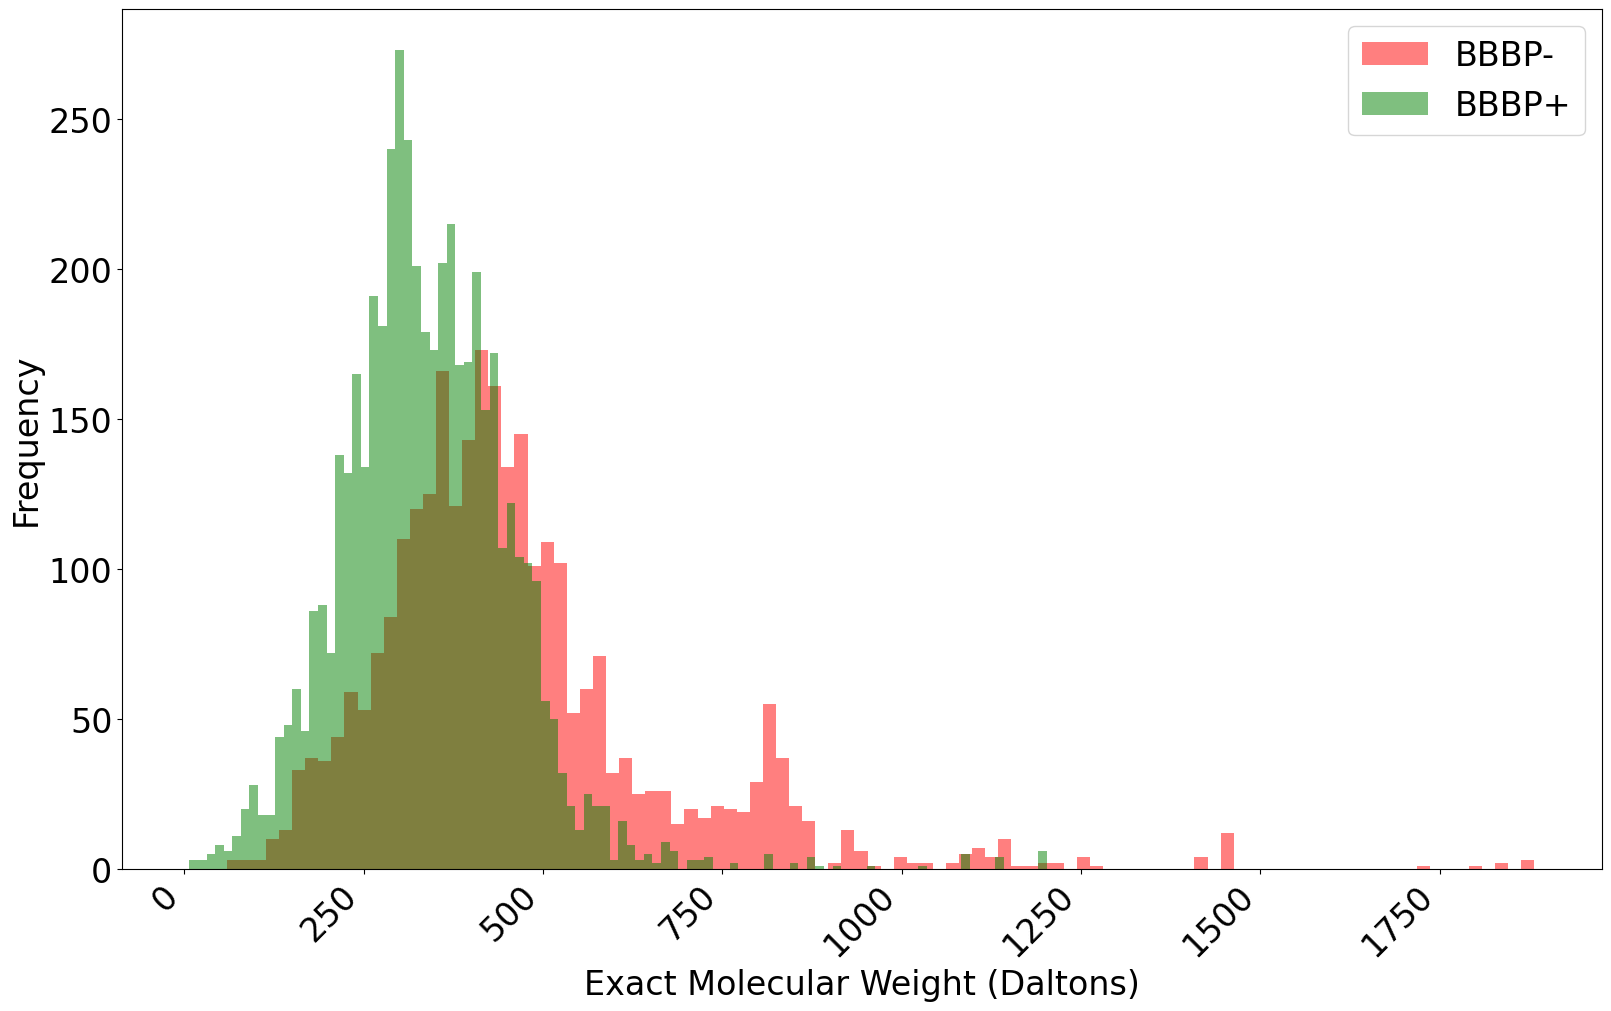

In [6]:
if has_rdkit:
    molwt = np.zeros(len(data))
    for i, smile in enumerate(smiles):
        molwt[i] = Chem.Descriptors.MolWt(Chem.MolFromSmiles(smile))

    np.save('molwt.npy', molwt)
else:
    molwt = np.load('molwt.npy')

plt.figure(figsize=(16, 10), layout='constrained')
plt.hist(molwt[y==0], bins=100, color='red', label='BBBP-', alpha=0.5)
plt.hist(molwt[y==1], bins=100, color='green', label='BBBP+', alpha=0.5)
plt.ylabel('Frequency')
plt.xlabel('Exact Molecular Weight (Daltons)')
plt.legend()
plt.xticks(rotation=45, ha='right')

In [7]:
if has_rdkit:
    print('Computing clique decomposition')

    cliques, vocab = get_clique_decomposition(smiles)
    X = cliques.to_numpy().astype(int)
    vocab = np.array(vocab)

    X_present = (X > 0).astype(np.float32)
    X_counts = X_present.sum(axis=0)

    np.save('vocab.npy', vocab)
    np.save('X_counts.npy', X_counts)
else:
    vocab = np.load('vocab.npy')
    X_counts = np.load('X_counts.npy')

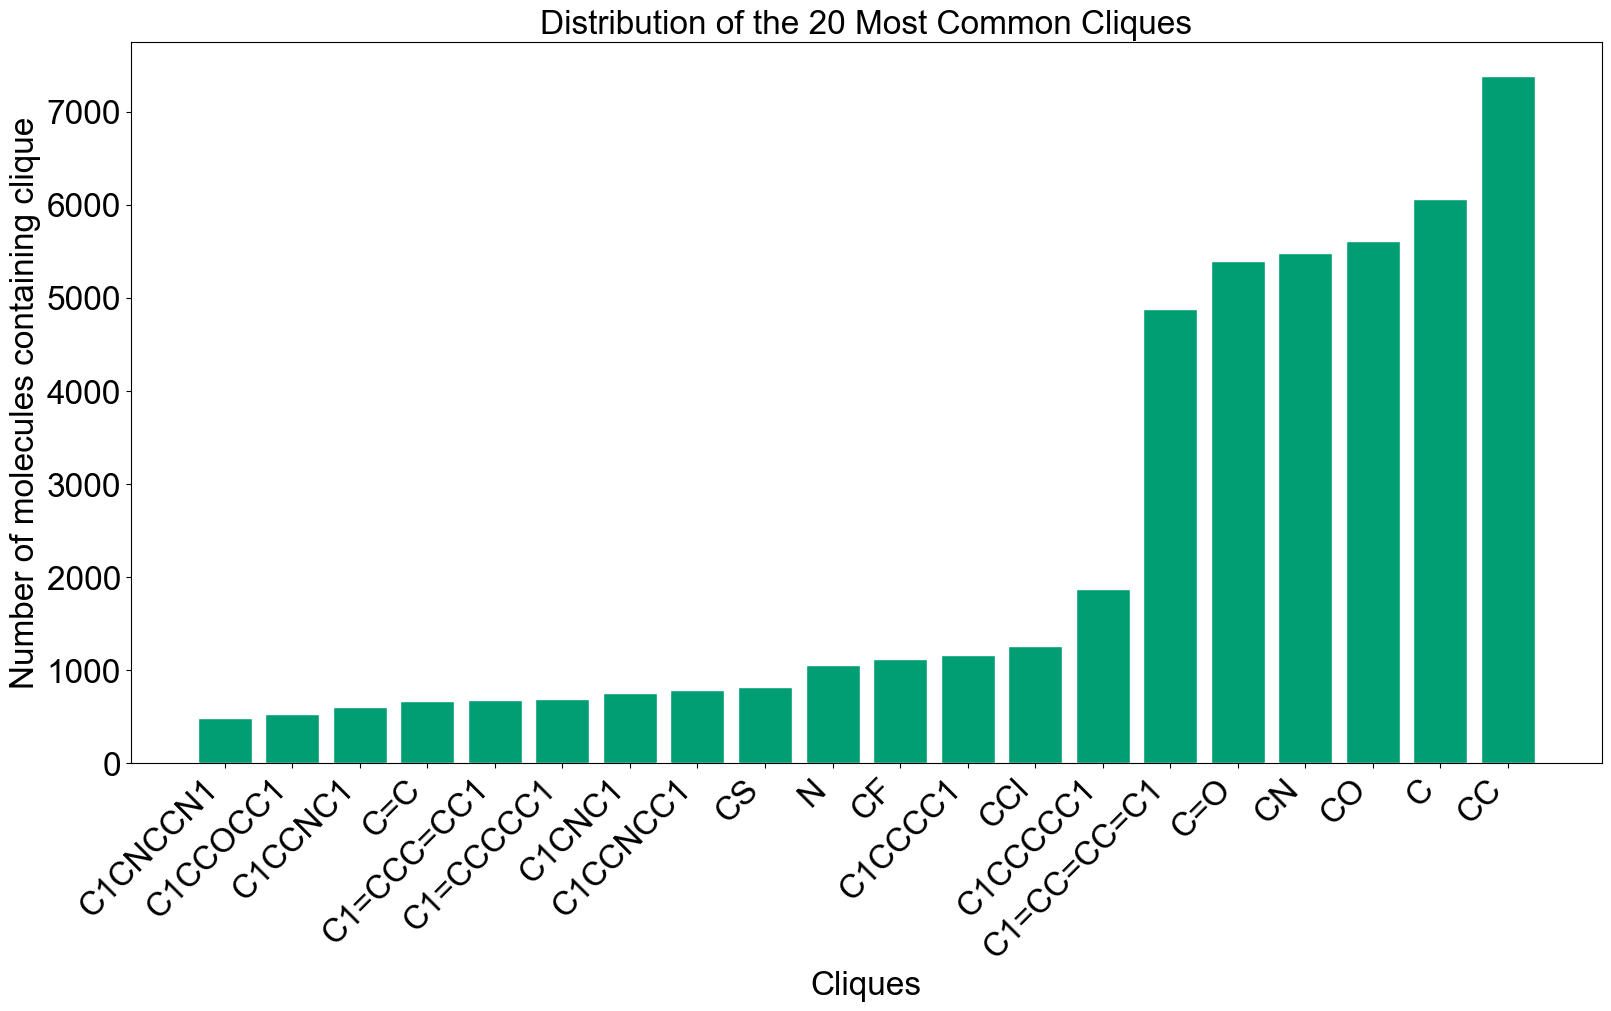

In [8]:
top_counts = np.argsort(X_counts)[-20:]
vocab_selected = vocab[top_counts]
X_counts_selected = X_counts[top_counts]

fig, ax = plt.subplots(figsize=(16, 10), layout='constrained')
sns.set(font_scale=2.0)
ax.bar(np.arange(len(vocab_selected)), X_counts_selected, color=cmap_discrete[2], width=0.8)
ax.set_ylabel('Number of molecules containing clique')
ax.set_xlabel('Cliques')
ax.set_title('Distribution of the 20 Most Common Cliques')
ax.set_xticks(np.arange(len(vocab_selected)), vocab_selected, rotation=45, ha='right')

(array([-10.,  -5.,   0.,   5.,  10.,  15.]),
 [Text(-10.0, 0, '−10'),
  Text(-5.0, 0, '−5'),
  Text(0.0, 0, '0'),
  Text(5.0, 0, '5'),
  Text(10.0, 0, '10'),
  Text(15.0, 0, '15')])

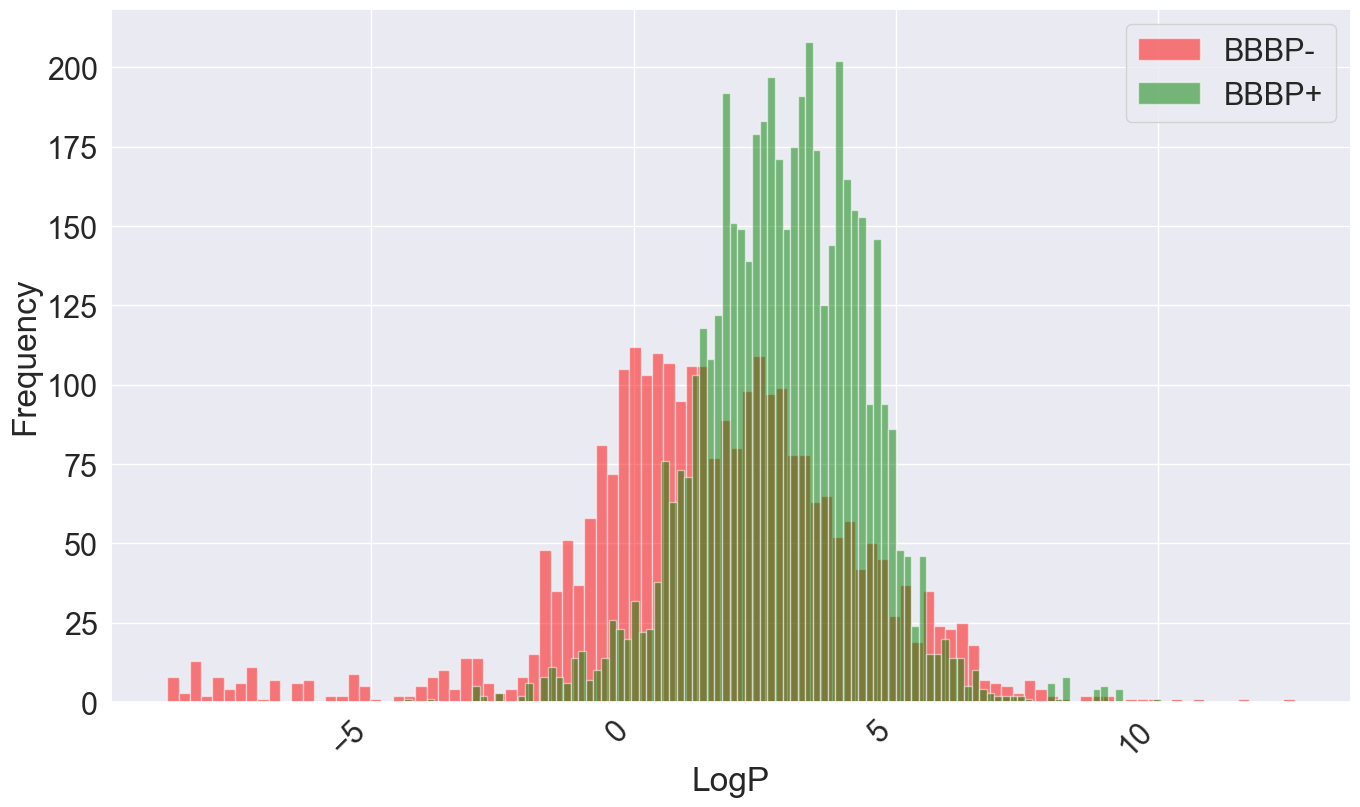

In [9]:
if has_rdkit:
    logP = np.zeros(len(data))
    for i, smile in enumerate(smiles):
        logP[i] = Chem.Descriptors.MolLogP(Chem.MolFromSmiles(smile))

    np.save('logP.npy', logP)
else:
    logP = np.load('logP.npy')

plt.figure(figsize=(16, 9))
plt.hist(logP[y==0], bins=100, color='red', label='BBBP-', alpha=0.5)
plt.hist(logP[y==1], bins=100, color='green', label='BBBP+', alpha=0.5)
plt.ylabel('Frequency')
plt.xlabel('LogP')
plt.legend()
plt.xticks(rotation=45, ha='right')

In [10]:
# Bernoulli Naive Bayes
# Note, this plot is more for sanity checking than anything else, since we never actually do prediction using it
# We only use it to obtain statistics on correlations between individual clique presence
if has_rdkit:
    cm = np.zeros((10, 5, 2, 2))
    mcc = np.zeros((10, 5,))
    auc = np.zeros((10, 5,))
    for i in range(10):
        kf = KFold(n_splits=5, shuffle=True, random_state=i)
        for j, (train_index, test_index) in enumerate(kf.split(X)):
            X_train, X_test = X_present[train_index], X_present[test_index]
            y_train, y_test = y[train_index], y[test_index]
        
            clf = BernoulliNB().fit(X_train, y_train)
            pred_test = clf.predict(X_test)
            pred_proba_test = clf.predict_proba(X_test)[:, 1]
        
            cm[i, j] = confusion_matrix(y_test, pred_test)
            mcc[i, j] = matthews_corrcoef(y_test, pred_test)
            auc[i, j] = roc_auc_score(y_test, pred_proba_test)
    
    cm = np.sum(cm, axis=1)
    cm = cm / np.unique(y, return_counts=True)[1][:, None]
    cm_mean = np.mean(cm, axis=0)
    cm_std = np.std(cm, axis=0)
    print(cm_std)
    print(cm_mean)
    print(cm_std)
    
    plt.figure(figsize=(10, 8))
    sns.set(font_scale = 2.0)
    cmap = sns.color_palette("Blues", as_cmap=True)
    
    cm_labels = np.asarray([['{0:.4f}'.format(cm_mean[i,j]) + '\n+- ' + '{0:.4f}'.format(cm_std[i,j]) for j in range(2)] for i in range(2)])
    ax = sns.heatmap(cm_mean, annot=cm_labels, fmt='', cmap=cmap, vmin=0, vmax=1)
    ax.set_xlabel('Predicted Class')
    ax.set_ylabel('True Class')
    
    ax.xaxis.set_ticklabels(['BBBP-', 'BBBP+'])
    ax.yaxis.set_ticklabels(['BBBP-', 'BBBP+'])
    
    print('Overall Mean ROC AUC', np.mean(auc), '+-', np.std(np.mean(auc, axis=1)))
    print('Overall Mean Matthews Correlation Coefficient', np.mean(mcc), '+-', np.std(np.mean(auc, axis=1)))

    clf = BernoulliNB().fit(X_present, y)
    
    logpx_y = clf.feature_log_prob_[1]
    logpx = np.log(np.exp(clf.feature_log_prob_[0]) * (1 - np.mean(y)) + np.exp(clf.feature_log_prob_[1]) * np.mean(y))
    logpy_x = logpx_y + np.log(np.mean(y)) - logpx
    py_x = np.exp(logpy_x)

    np.save('py_x.npy', py_x)
else:
    py_x = np.load('py_x.npy')

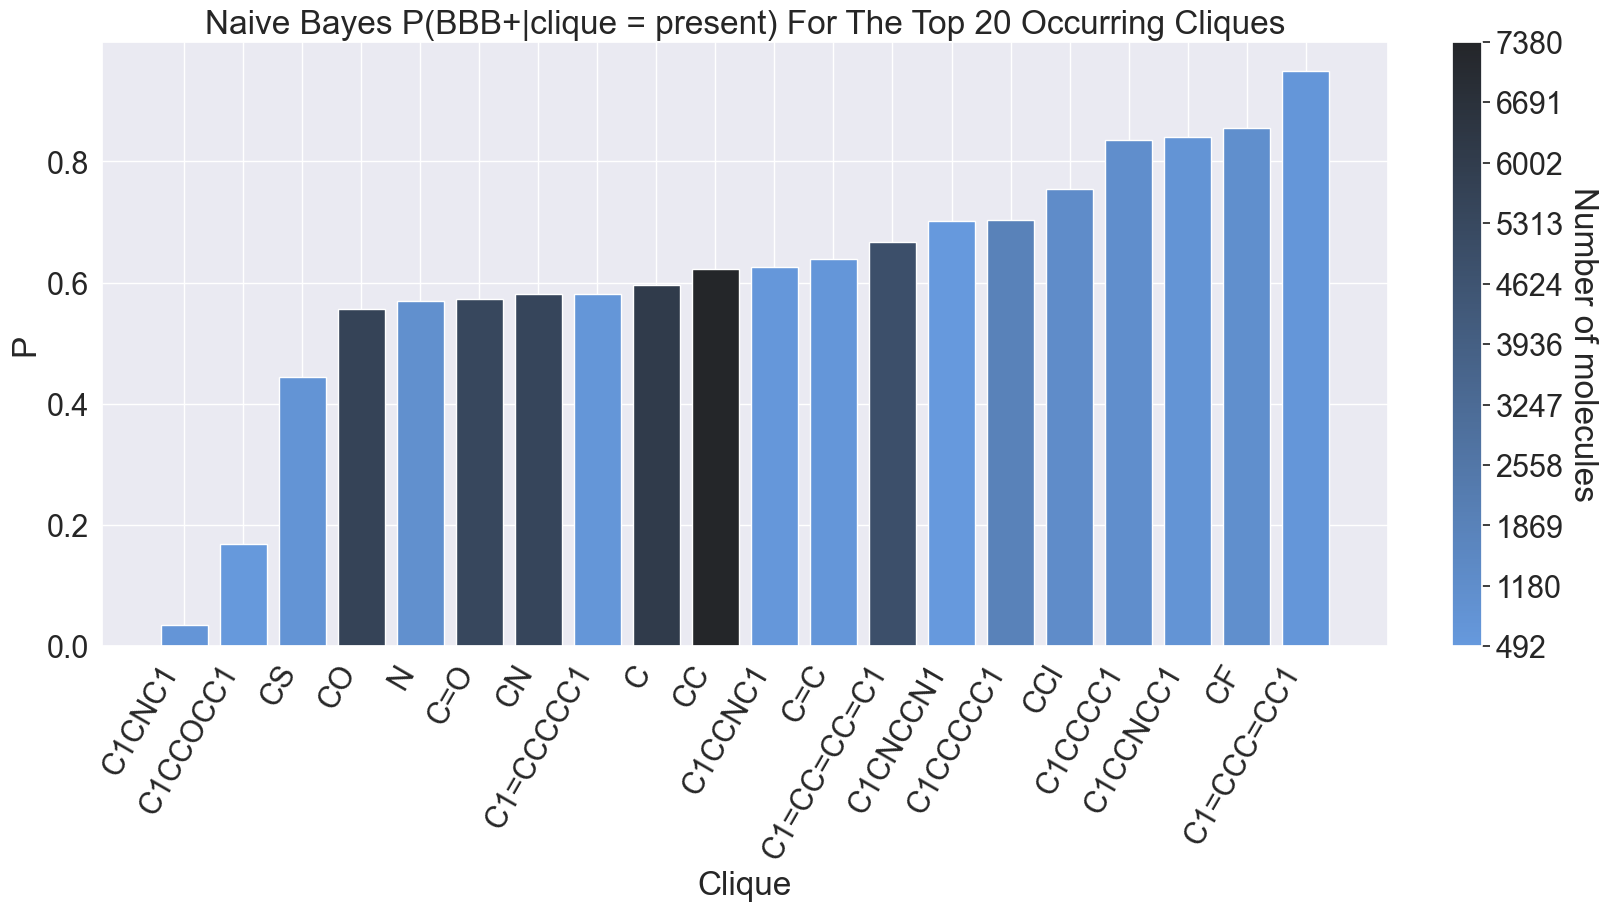

In [11]:
order = np.argsort(py_x[top_counts])
vocab_selected = vocab[top_counts][order]
py_x_selected = py_x[top_counts][order]
X_counts_selected = X_counts[top_counts][order]
counts_color = cmap_continuous((X_counts_selected - np.min(X_counts_selected)) / (np.max(X_counts_selected) - np.min(X_counts_selected)))

fig, ax = plt.subplots(figsize=(16, 9), layout='constrained')
bar = ax.bar(np.arange(len(py_x_selected)), py_x_selected, color=counts_color, width=0.8)
ax.set_title('Naive Bayes P(BBB+|clique = present) For The Top 20 Occurring Cliques')
ax.set_ylabel('P')
ax.set_xticks(np.arange(len(py_x_selected)), vocab_selected, rotation=60, ha='right')
ax.set_xlabel('Clique')
sm = ScalarMappable(cmap=cmap_continuous)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_ticks(ticks=np.linspace(0, 1, 11), labels=np.linspace(np.min(X_counts_selected), np.max(X_counts_selected), 11).astype(np.int32))
cbar.set_label('Number of molecules', rotation=270, labelpad=25)

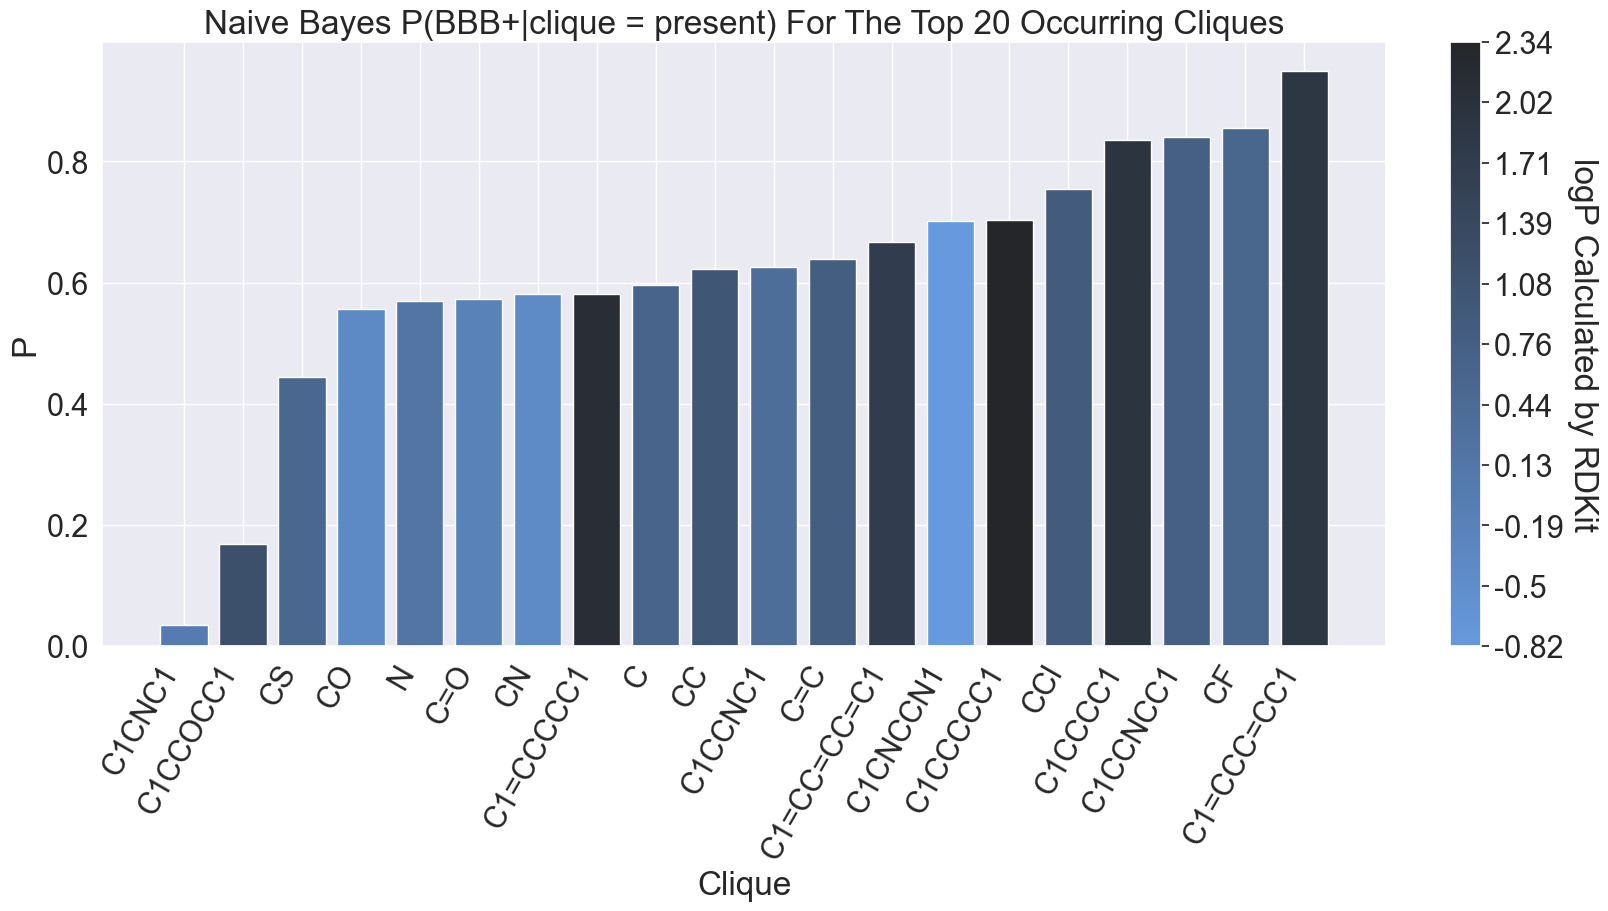

In [12]:
if has_rdkit:
    logP_selected = np.zeros(len(vocab_selected))
    for i, smile in enumerate(vocab_selected):
        logP_selected[i] = Chem.Descriptors.MolLogP(Chem.MolFromSmiles(smile))

    np.save('logP_selected.npy', logP_selected)
else:
    logP_selected = np.load('logP_selected.npy')

logP_color = cmap_continuous((logP_selected - np.min(logP_selected)) / (np.max(logP_selected) - np.min(logP_selected)))
# Plot the best clique combinations with logP
fig, ax = plt.subplots(figsize=(16, 9), layout='constrained')
bar = ax.bar(np.arange(len(py_x_selected)), py_x_selected, color=logP_color, width=0.8)
ax.set_title('Naive Bayes P(BBB+|clique = present) For The Top 20 Occurring Cliques')
ax.set_ylabel('P')
ax.set_xticks(np.arange(len(py_x_selected)), vocab_selected, rotation=60, ha='right')
ax.set_xlabel('Clique')
sm = ScalarMappable(cmap=cmap_continuous)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_ticks(ticks=np.linspace(0, 1, 11), labels=np.around(np.linspace(np.min(logP_selected), np.max(logP_selected), 11), decimals=2))
cbar.set_label('logP Calculated by RDKit', rotation=270,labelpad=25)